# Read and plot the results

In this notebook you can find all the functions we used to plot the function that are in our paper.

In [6]:
import rankedDelegation as rd
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
import matplotlib.pyplot as plt
import pulp
import time
import seaborn as sns
import tikzplotlib
np.random.seed(42)

In [7]:
font = {'size'   : 16}
import matplotlib
matplotlib.rc('font', **font)

## Load results

In [8]:
def count_voters(name, synthetic=True):
    list_df = []
    i = 0
    tab = []
    directory = r'./Save/'
    if synthetic:
        directory += 'Synthetic/'
    nodes = np.genfromtxt(r'%snodes_%s'%(directory,name), dtype=int)
    edges = np.genfromtxt(r'%sedges_%s'%(directory,name), dtype=int)
    e = rd.Election()
    for n in nodes:
        if n[1]:
            v = rd.Voter(vote=np.random.randint(2))
        else:
            v = rd.Voter()
        e.add_voter(v)
            
    L = e.list_voters
    n = len(L)
    delegatees_list = [[] for i in range(n)]
    for edge in edges:
        delegatees_list[edge[0]].append(L[edge[1]])

    for voter in L:
        voter.delegate(delegatees_list[voter.id])
                
    e.attribute_gurus(rd.rules.depthFirst)
    
    c = 0
    for v in e.list_voters:
        if v.vote is not None:
            c += 1
        elif v.guru is not None:
            c += 1
    return c

## Heatmap of the performance with the different metrics

In [9]:
def load_results(name, synthetic=True):
    list_df = []
    directory = r'./Save/'
    if synthetic:
        directory += 'Synthetic/'
    for f in os.listdir(directory):
        if (f.split("_")[0] == "results") and (name == f.split("_")[1]):
            df = pd.read_csv(r'%s%s'%(directory,f), index_col=0)
            c = count_voters("_".join(f.split("_")[1:]), synthetic)
            df["Unpopularity"] = df["Unpopularity"]/c
            list_df.append(df)
            
    rules = ["BFD", "MinSumPath", "LexRank", "Diffusion", "MinArb", "DFD"]
    metrics = ["Max Length", "Avg Length", "Max representation", "Max Sum","Max Rank", "Avg Rank", "Unpopularity"]
    df_concat = pd.concat(list_df)
    by_row_index = df_concat.groupby(df_concat.index)
    df_means = by_row_index.mean().round(2)[metrics].transpose()[rules].transpose()
    
    df_means_n = df_means.subtract(df_means.min(axis=0) ,axis=1)
    df_means_n = df_means_n.div(df_means_n.max(axis=0), axis=1)

 
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.pcolor(df_means_n.values, cmap=plt.get_cmap("Wistia"))

    
    plt.yticks(np.arange(len(rules))+0.5, rules)
    plt.xticks(np.arange(len(metrics))+0.5, metrics)
    
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    for i in range(len(rules)):
        for j in range(len(metrics)):
            v = df_means.values[i,j]
            color = "k"
            text = ax.text(j+0.5,i+0.5,v ,
                           ha="center", va="center", color=color)
    plt.savefig("figure_results_%s.png"%name)
    
    tikzplotlib.clean_figure()
    tikzplotlib.save("figure_results_%s.tex"%name,  axis_height ='6cm', axis_width ='14cm')
    plt.show()
    
    
        

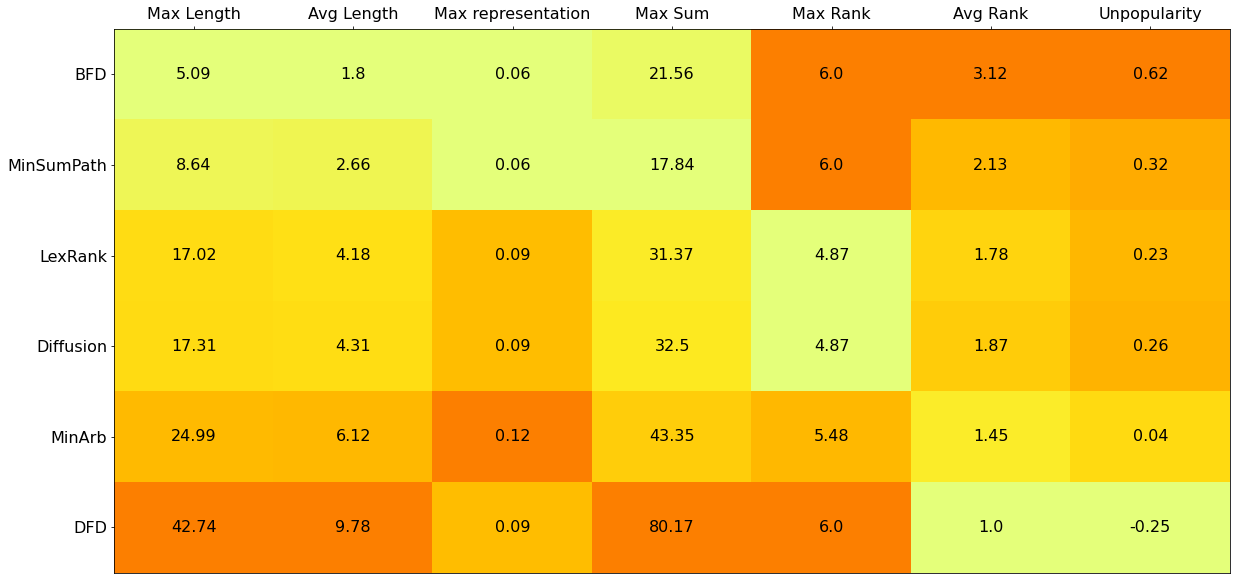

In [10]:
load_results("space")

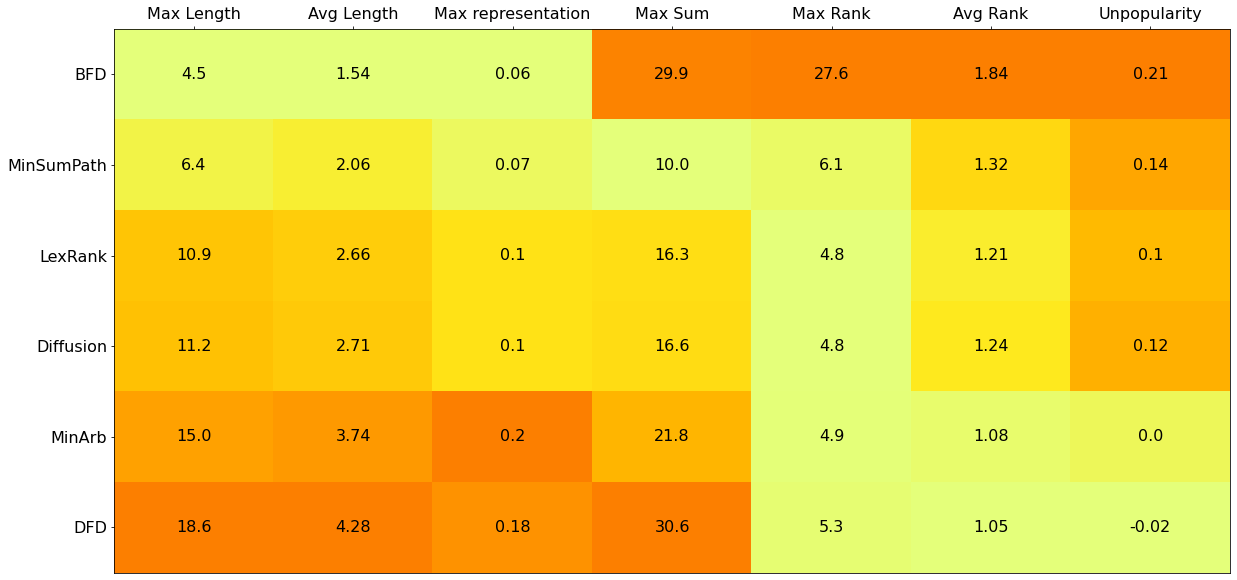

In [11]:
load_results("Bitcoin OTC", False)

# Evolution of the abstention rate

In [13]:
def distrib_voters(e):
    tab = np.zeros(4)
    for v in e.list_voters:
        if v.vote is not None:
            tab[0] += 1
        elif v.guru is not None:
            tab[1] += 1
        elif len(v.delegatees) > 0:
            tab[2] += 1
        else:
            tab[3] += 1
    tab /= np.sum(tab)
    return tab


def load_election(name, limit= 100):
    list_df = []
    i = 0
    tab = []
    for f in os.listdir(r'./Save/Synthetic'):
        if (f.split("_")[0] == "nodes") and (name == f.split("_")[1]):
            #print(i)
            i += 1
            nodes = np.genfromtxt(r'./Save/Synthetic/%s'%f, dtype=int)
            e = rd.Election()
            for n in nodes:
                if n[1]:
                    v = rd.Voter(vote=np.random.randint(2))
                else:
                    v = rd.Voter()
                e.add_voter(v)
            
            edges = np.genfromtxt(r'./Save/Synthetic/edges_%s'%("_".join(f.split("_")[1:])), dtype=int)
            
            #print("Construction")
            L = e.list_voters
            n = len(L)
            delegatees_list = [[] for i in range(n)]
            for edge in edges:
                if (edge[2] <= limit):
                    delegatees_list[edge[0]].append(L[edge[1]])

            for voter in L:
                voter.delegate(delegatees_list[voter.id])
                
            #print("Assignation")
            e.attribute_gurus(rd.rules.depthFirst)
            tab.append(distrib_voters(e))
        
    tab = np.array(tab)
    cat = ["Casting voters", "Delegating voters", "Isolated voters", "Abstaining voters"]
    tabmean = tab.mean(axis=0)
    tabstd = tab.std(axis=0)
    for i in range(4):
        print("%s : %.2f%% (std : %.2f)"%(cat[i], tabmean[i]*100, tabstd[i]*100))
    

In [14]:
load_election("pop1000-0.90")

Casting voters : 10.07% (std : 0.99)
Delegating voters : 88.21% (std : 0.87)
Isolated voters : 0.11% (std : 0.12)
Abstaining voters : 1.61% (std : 0.41)


In [15]:
def read_election(f, limit):
            nodes = np.genfromtxt(r'./Save/Synthetic/%s'%f, dtype=int)
            e = rd.Election()
            for n in nodes:
                if n[1]:
                    v = rd.Voter(vote=np.random.randint(2))
                else:
                    v = rd.Voter()
                e.add_voter(v)
            
            edges = np.genfromtxt(r'./Save/Synthetic/edges_%s'%("_".join(f.split("_")[1:])), dtype=int)
            
            #print("Construction")
            L = e.list_voters
            n = len(L)
            delegatees_list = [[] for i in range(n)]
            for edge in edges:
                if (edge[2] <= limit):
                    delegatees_list[edge[0]].append(L[edge[1]])

            for voter in L:
                voter.delegate(delegatees_list[voter.id])
                
            return e
            #print("Assignation")
            

def evol_abstaining(name):
    list_df = []
    i = 0
    tab = []
    for f in os.listdir(r'./Save/Synthetic'):
        if (f.split("_")[0] == "nodes") and (name == f.split("_")[1]):
            #print(i)
            i += 1
            tabi = []
            for limit in range(5):
                e = read_election(f, limit)
                e.attribute_gurus(rd.rules.depthFirst)
                d = distrib_voters(e)
                tabi.append(d[0] + d[1])
            tab.append(tabi)
                
                
        
    tab = np.array(tab)
    tabmean = tab.mean(axis=0)
    tabstd = tab.std(axis=0)
    print(tabmean)
    plt.figure(figsize=(15,5))
    
    plt.fill_between(np.arange(5), 1-(tabmean-tabstd), 1-(tabmean+tabstd), alpha=0.2)
    plt.plot(np.arange(5), 1-tabmean,"o-")
    plt.title(name)
    plt.xlabel("Maximum outdegree")
    plt.ylabel("Abstention rate")
    plt.ylim(0,1)
    plt.xlim(0,4)
    plt.show()
    

[0.10290099 0.23425743 0.55138614 0.88486139 0.9830297 ]


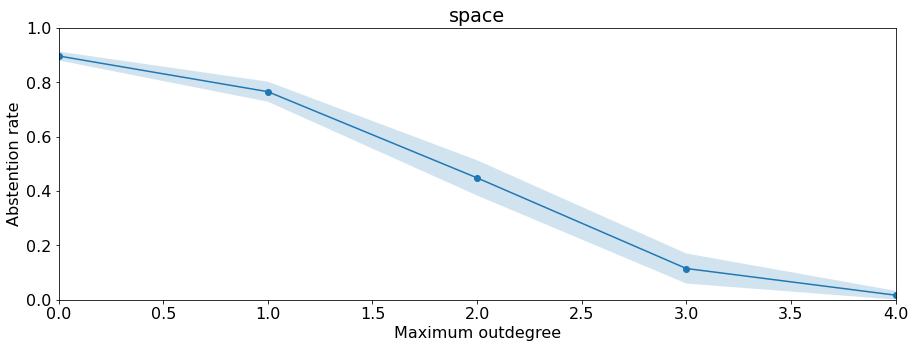

In [16]:
evol_abstaining("space")

In [17]:

def evol_abstaining_comp(name):
    
    plt.figure(figsize=(8,5))
    list_prop = ["0.50", "0.80", "0.90", "0.95","0.99"]
    
    names = ["%s-%s"%(name,x) for x in list_prop]
    labels = ["50% casting", "20% casting", "10% casting", "5% casting", "1% casting"]
    for j, name in enumerate(names):
        list_df = []
        i = 0
        tab = []
        for f in os.listdir(r'./Save/Synthetic'):
            if (f.split("_")[0] == "nodes") and (name == f.split("_")[1]):
                i += 1
                tabi = []
                for limit in range(5):
                    e = read_election(f, limit)
                    e.attribute_gurus(rd.rules.depthFirst)
                    d = distrib_voters(e)
                    tabi.append(d[0] + d[1])
                tab.append(tabi)


        tab = np.array(tab)
        tabmean = tab.mean(axis=0)
        tabstd = tab.std(axis=0)
        plt.fill_between(np.arange(5), 1-(tabmean-tabstd), 1-(tabmean+tabstd), alpha=0.2)
        plt.plot(np.arange(5), 1-tabmean,"o-",label=labels[j])
    plt.title("Impact of backup delegation")
    plt.xlabel("Maximum outdegree")
    plt.ylabel("Abstention rate")
    plt.ylim(0,1)
    plt.xlim(0,4)
    plt.grid()
    plt.legend()
    plt.savefig("figure_abstention_%s.png"%name)
    
    tikzplotlib.clean_figure()
    tikzplotlib.save("figure_abstention_%s.tex"%name,  axis_height ='6cm', axis_width ='10cm')
    
    plt.show()

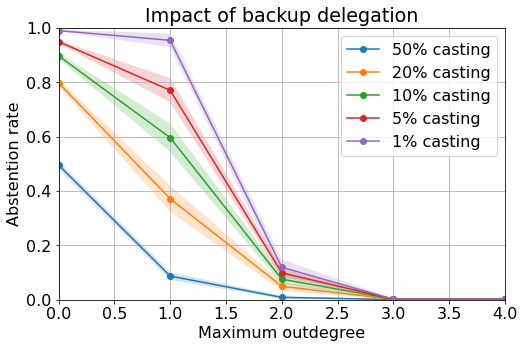

In [18]:
evol_abstaining_comp("friendshard1000")